# Data from Analise's Thesis

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
from src.plot_utils import PlotUtils
from src.analise_thesis.plotter import Plotter
import matplotlib.pyplot as plt
from pprint import pprint

### Set general figure parameters

In [3]:
home = os.path.expanduser("~")
figure_store_path = os.path.join(home, 'data/figs_sensors_actuators')
os.makedirs(figure_store_path, mode = 0o777, exist_ok = True)
fig_format = 'svg'
tick_fontsize = 14
aspect = 1 # both axes are of equal length (square plot)
PlotUtils.set_user_figure_dir(user_fig_directory=figure_store_path)

## Hard chip data

In [4]:
data_hard = [
    (896, 1, 'hard'),
    (764, 1, 'hard'),
    (608, 1, 'hard'),
    (512, 1, 'hard'),
    (764, 2, 'hard'),
    (608, 2, 'hard'),
    (512, 2, 'hard'),
    (384, 2, 'hard'),
    (288, 2, 'hard'),
    (996, 3, 'hard'),
    (800, 3, 'hard'),
    (764, 3, 'hard'),
    (764, 4, 'hard'),
    (512, 4, 'hard'),
    (384, 4, 'hard'),
    (192, 4, 'hard'),
    ]
plotter_hard = Plotter(data = data_hard, nrows = 1, ncols = 1,
                       xlabel = "Injection number", ylabel = 'Resistance [K$\Omega$]',
                       xlim = [0, 5], ylim = [0, 1e6], capsize = 10,
                       fig_format = fig_format, fontsize=tick_fontsize)

In [5]:
plotter_hard.sort_tuples(data=data_hard, idx_to_sort_by=0)
pprint(data_hard)
# special = filter_by_width(data, 764)
# print(special)

[(192, 4, 'hard'),
 (288, 2, 'hard'),
 (384, 2, 'hard'),
 (384, 4, 'hard'),
 (512, 1, 'hard'),
 (512, 2, 'hard'),
 (512, 4, 'hard'),
 (608, 1, 'hard'),
 (608, 2, 'hard'),
 (764, 1, 'hard'),
 (764, 2, 'hard'),
 (764, 3, 'hard'),
 (764, 4, 'hard'),
 (800, 3, 'hard'),
 (896, 1, 'hard'),
 (996, 3, 'hard')]


### Create plots for each data tuple for all hard data

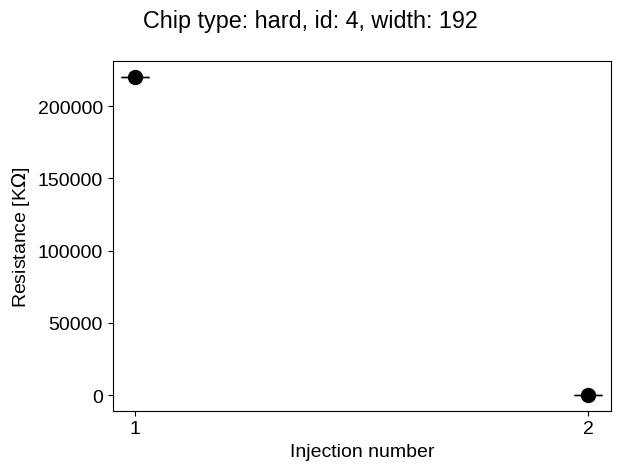

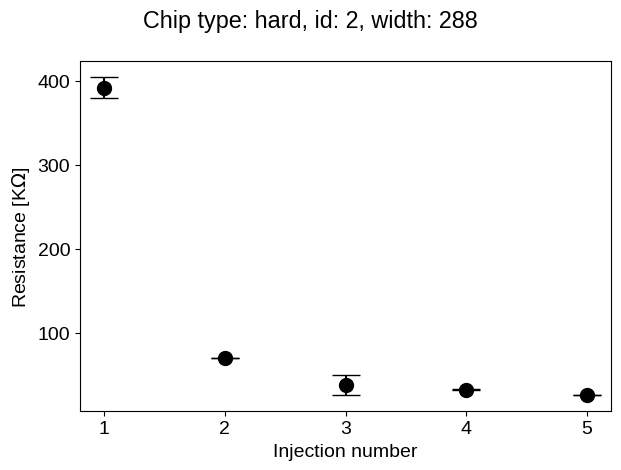

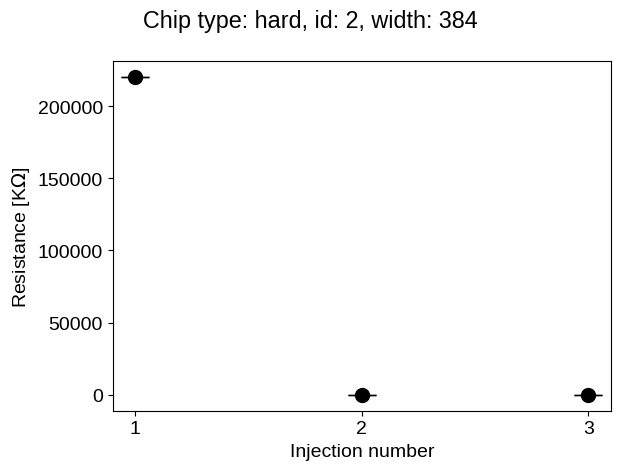

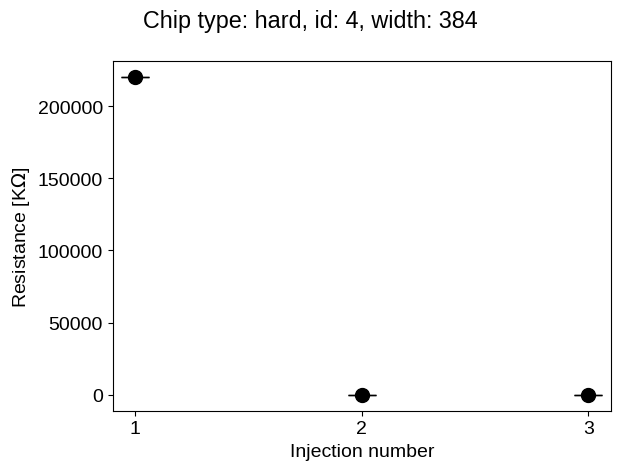

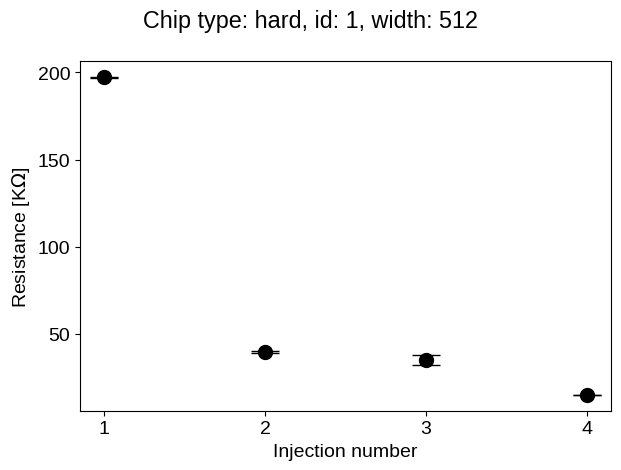

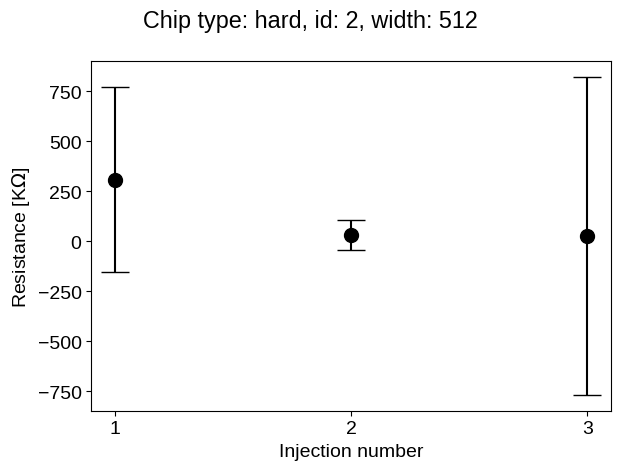

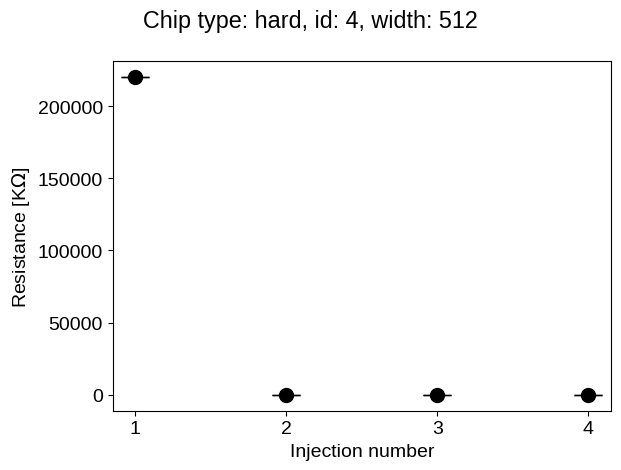

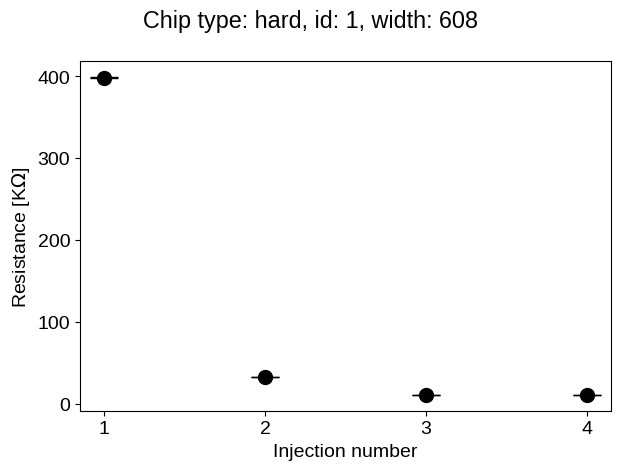

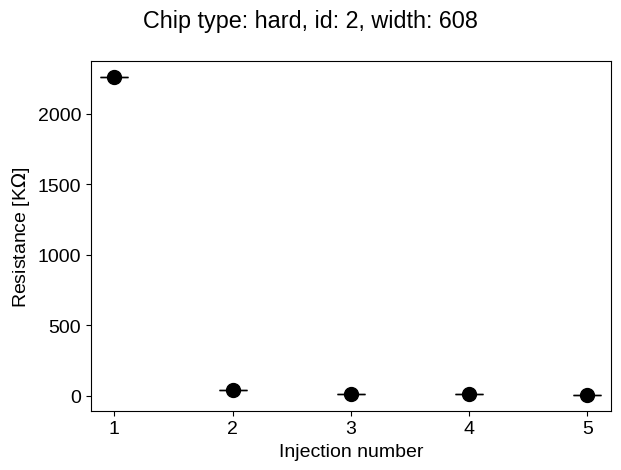

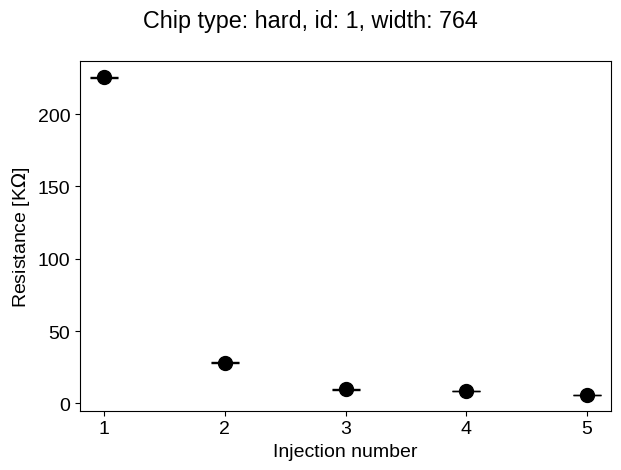

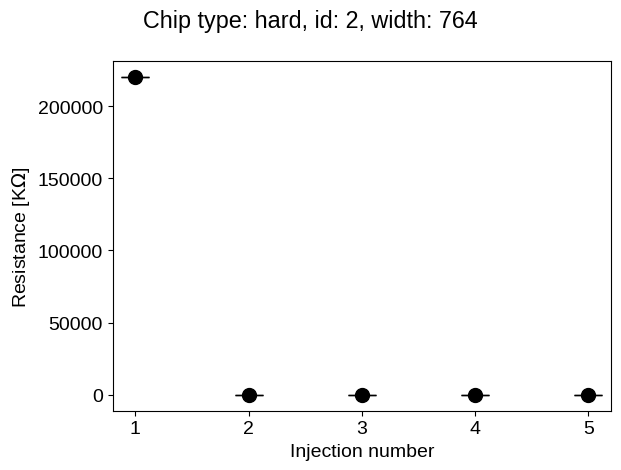

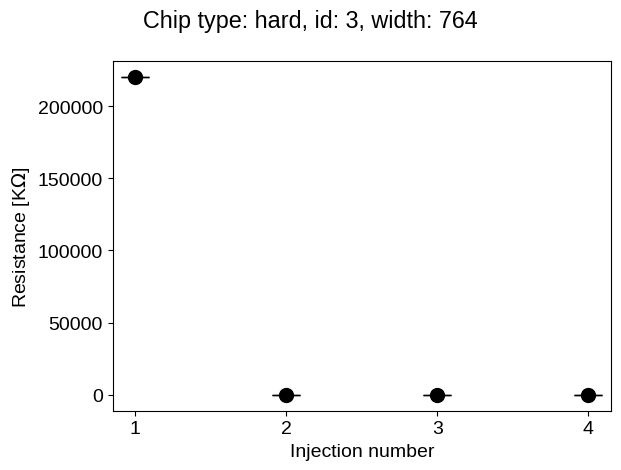

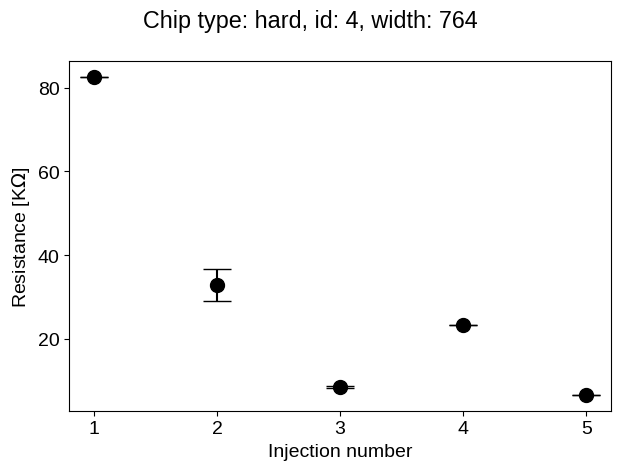

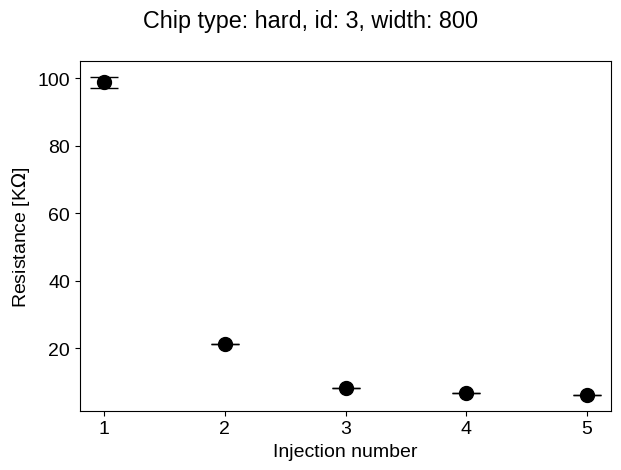

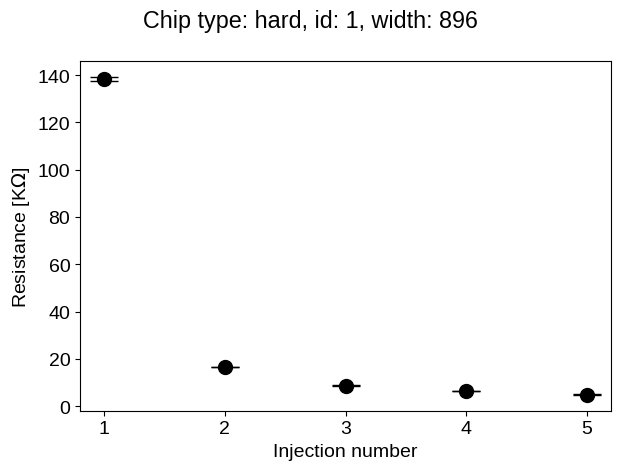

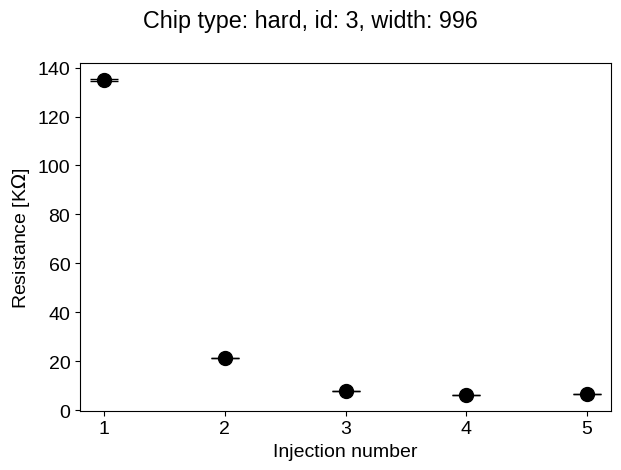

In [6]:
plotter_hard.run_individual_chips()

### Create a Pandas Dataframe for all _hard_ data

processing chip ID: (192, 4, 'hard')
aggregate from channel_datum: Channel Data: width: 192
xdata: [1, 2]
ydata: [220000.0, 198.8]
yerr: [0.0, 0.03857]

item in ydata__aggregated: ([220000.0, 198.8], [0.0, 0.03857])
data type of restructured_data: <class 'list'>
'item: [(220000.0, 0.0)]'
'item: [(198.8, 0.03857)]'
stddevs: [10.0]
cls.weights: [0.01]
weighted_ydata_: 220000.0, weighted_yerr_: 100.0
stddevs: [0.03857]
cls.weights: [672.2034270409557]
weighted_ydata_: 198.8, weighted_yerr_: 0.38570000000000004
printing: width_192_type_hard_weighted_data.svg
processing chip ID: (288, 2, 'hard')
aggregate from channel_datum: Channel Data: width: 288
xdata: [1, 2, 3, 4, 5]
ydata: [391.8, 70.26, 38.02, 32.62, 26.44]
yerr: [12.36, 0.2169, 11.41, 0.2453, 0.1032]

item in ydata__aggregated: ([391.8, 70.26, 38.02, 32.62, 26.44], [12.36, 0.2169, 11.41, 0.2453, 0.1032])
data type of restructured_data: <class 'list'>
'item: [(391.8, 12.36)]'
'item: [(70.26, 0.2169)]'
'item: [(38.02, 11.41)]'
'item: 

processing chip ID: (996, 3, 'hard')
aggregate from channel_datum: Channel Data: width: 996
xdata: [1, 2, 3, 4, 5]
ydata: [134.9, 21.25, 7.928, 6.265, 6.514]
yerr: [0.3484, 0.04319, 0.009346, 0.0653, 0.01494]

item in ydata__aggregated: ([134.9, 21.25, 7.928, 6.265, 6.514], [0.3484, 0.04319, 0.009346, 0.0653, 0.01494])
data type of restructured_data: <class 'list'>
'item: [(134.9, 0.3484)]'
'item: [(21.25, 0.04319)]'
'item: [(7.928, 0.009346)]'
'item: [(6.265, 0.0653)]'
'item: [(6.514, 0.01494)]'
stddevs: [0.3484]
cls.weights: [8.238415798777025]
weighted_ydata_: 134.9, weighted_yerr_: 3.484
stddevs: [0.04319]
cls.weights: [536.0849214268372]
weighted_ydata_: 21.25, weighted_yerr_: 0.4319
stddevs: [0.009346]
cls.weights: [11448.49626062346]
weighted_ydata_: 7.928, weighted_yerr_: 0.09345999999999999
stddevs: [0.0653]
cls.weights: [234.51662605620427]
weighted_ydata_: 6.265, weighted_yerr_: 0.6529999999999999
stddevs: [0.01494]
cls.weights: [4480.214476827435]
weighted_ydata_: 6.514, we

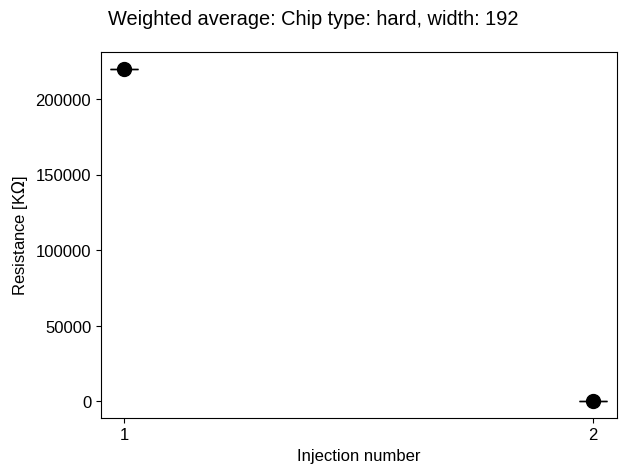

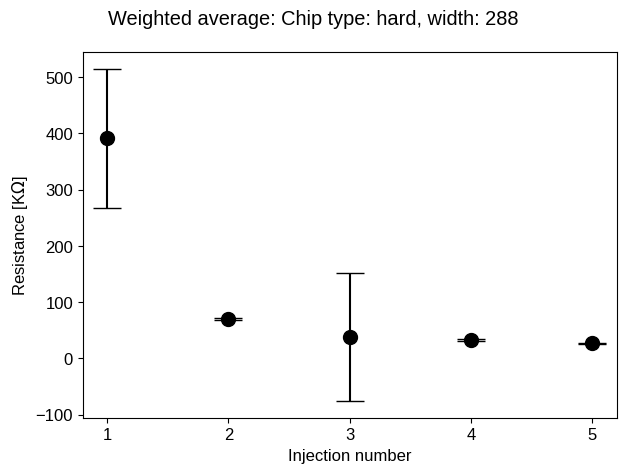

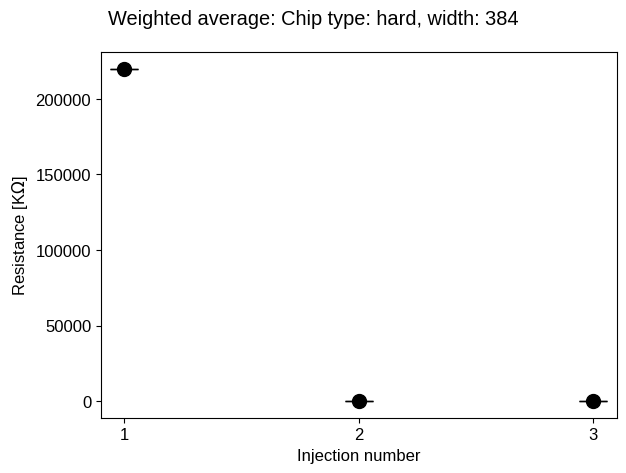

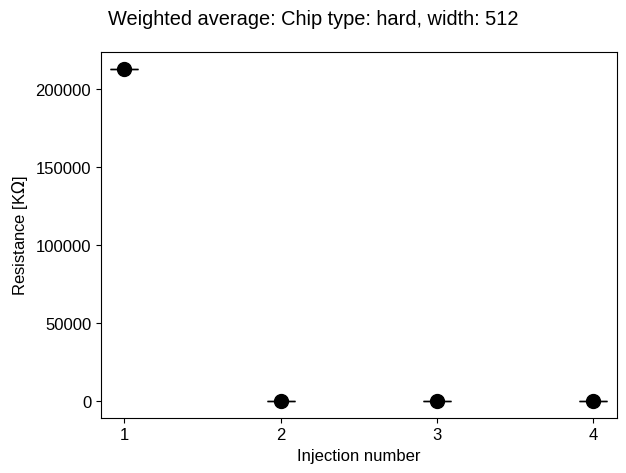

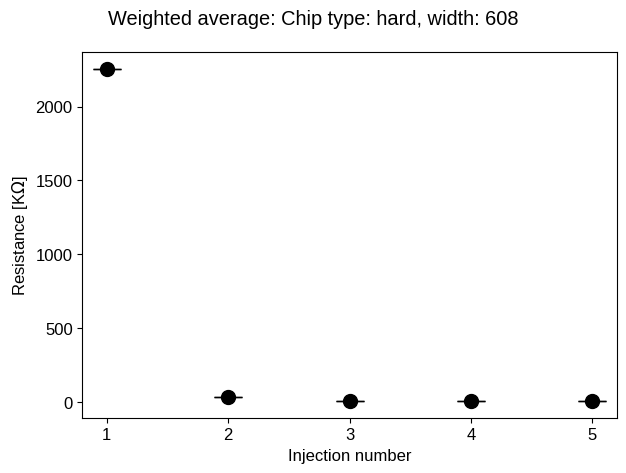

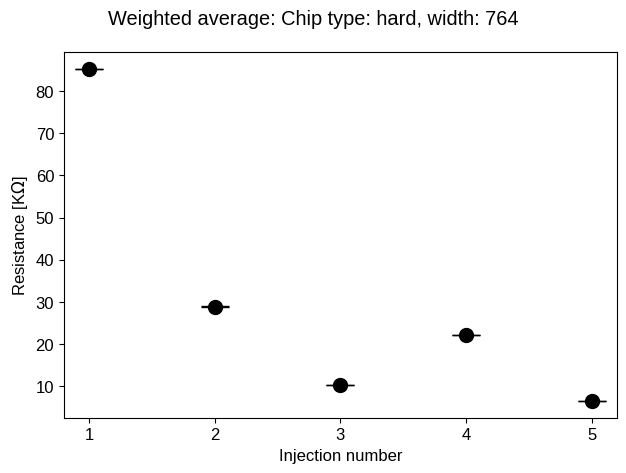

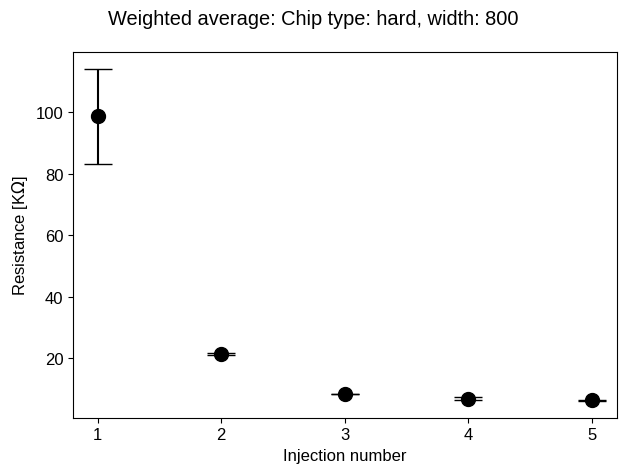

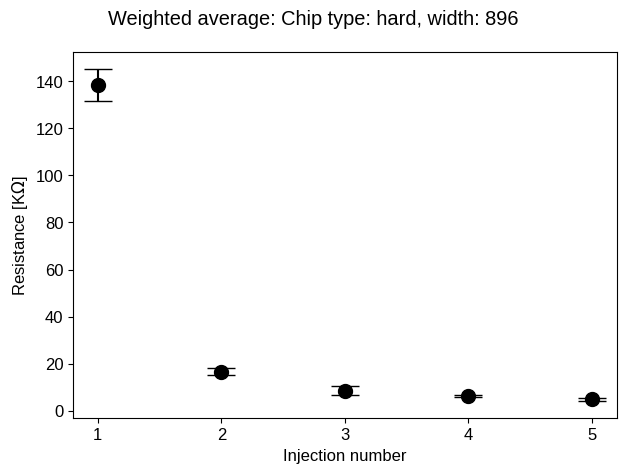

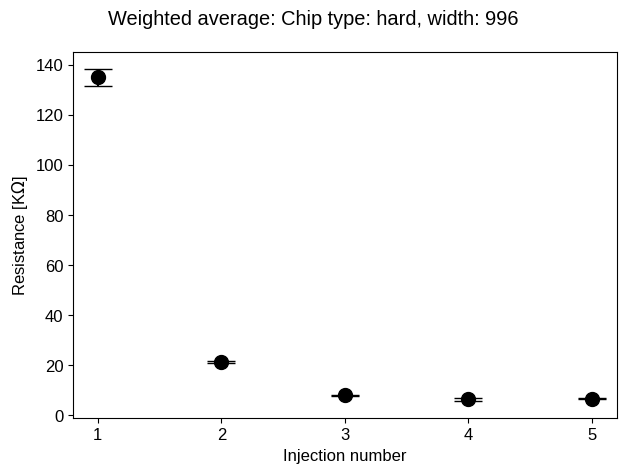

In [7]:
df = pd.DataFrame()
channel_widths = plotter_hard.get_channel_list()
for channel_width in channel_widths:
    data = plotter_hard.filter_by_width(width=channel_width)
    df_ = pd.DataFrame(plotter_hard.get_averaged_channel_data(data))
    df = pd.concat([df_, df])

### Print dataframe and write to disk as a CSV file

In [8]:
path = os.path.join(PlotUtils.glob_figpath, 'weighted_data_hard.csv')
df.to_csv(path)
df

,chip_width,chip_type,number_of_chips,x_data,number_of_injections,y_data,y_err
0,996,hard,1,1,5,134.900000,3.484000
1,996,hard,1,2,5,21.250000,0.431900
2,996,hard,1,3,5,7.928000,0.093460
3,996,hard,1,4,5,6.265000,0.653000
4,996,hard,1,5,5,6.514000,0.149400
0,896,hard,1,1,5,138.400000,6.969000
1,896,hard,1,2,5,16.590000,1.366000
2,896,hard,1,3,5,8.512000,2.016000
3,896,hard,1,4,5,6.235000,0.349100
4,896,hard,1,5,5,4.833000,0.728000


### Filter dataframe for the resistance at the last injection

In [9]:
df_last_injection = df.loc[df.x_data == df.number_of_injections]
df_last_injection

,chip_width,chip_type,number_of_chips,x_data,number_of_injections,y_data,y_err
4,996,hard,1,5,5,6.514000,0.149400
4,896,hard,1,5,5,4.833000,0.728000
4,800,hard,1,5,5,6.271000,0.206000
4,764,hard,4,5,5,6.576132,0.052175
4,608,hard,2,5,5,8.371000,0.298900
3,512,hard,3,4,4,18.578099,0.132399
2,384,hard,2,3,3,24.374414,0.025275
4,288,hard,1,5,5,26.440000,1.032000
1,192,hard,1,2,2,198.800000,0.385700


### Summary plots: resistance at each channel after last injection
The number of the last injection is variable, shown in the above tables in column `number_of_injections`.

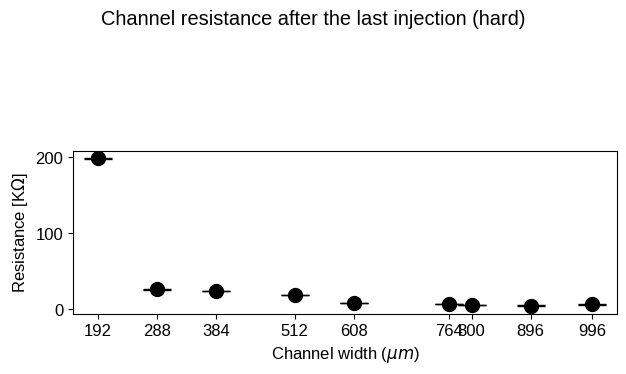

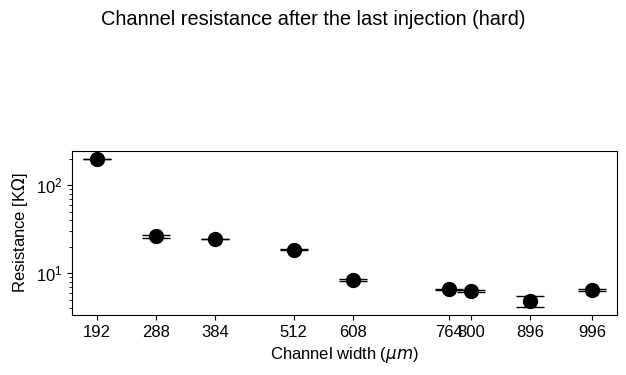

In [10]:
# print(df_last_injection.chip_width.to_list())
title = 'Channel resistance after the last injection (hard)'
xlabel = 'Channel width ($\mu m$)'
aspect = 0.3
# with linear y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_hard_linear.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err,
                       nrows=plotter_hard.nrows, ncols=plotter_hard.ncols, aspect = aspect,
                       xlabel=xlabel, ylabel=plotter_hard.ylabel, capsize=plotter_hard.capsize,
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format)
# with logarithmic y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_hard_logarithmic.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err,
                       nrows=plotter_hard.nrows, ncols=plotter_hard.ncols, aspect = aspect,
                       xlabel=xlabel, ylabel=plotter_hard.ylabel, capsize=plotter_hard.capsize,
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format, yscale='log')

## Soft chip data

In [11]:
data_soft = [
    (720, 1, 'soft'),
    (720, 3, 'soft'),
    (720, 5, 'soft'),
    (720, 6, 'soft'),
    (960, 1, 'soft'),
    (960, 5, 'soft'),
    (840, 1, 'soft'),
    (840, 5, 'soft'),
    (840, 6, 'soft'),
    (1080, 1, 'soft'),
    (1080, 2, 'soft'),
    (1080, 3, 'soft'),
    (1080, 5, 'soft'),
    (1080, 6, 'soft'),
    (1080, 7, 'soft'),
    (600, 2, 'soft'),
    (600, 3, 'soft'),
    (600, 5, 'soft'),
    (480, 2, 'soft'),
]
plotter_soft = Plotter(data = data_soft, nrows = 1, ncols = 1, 
                       xlabel = "Injection number", ylabel = 'Resistance [K$\Omega$]',
                       xlim = [0, 5], ylim = [0, 1e6], capsize = 10,
                       fig_format = fig_format)

### Create plots for each data tuple

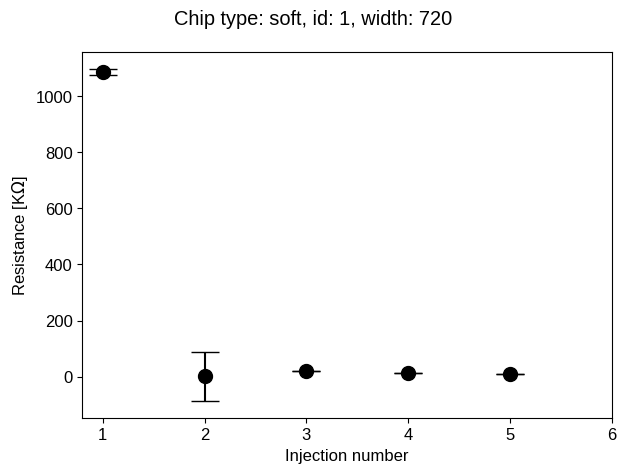

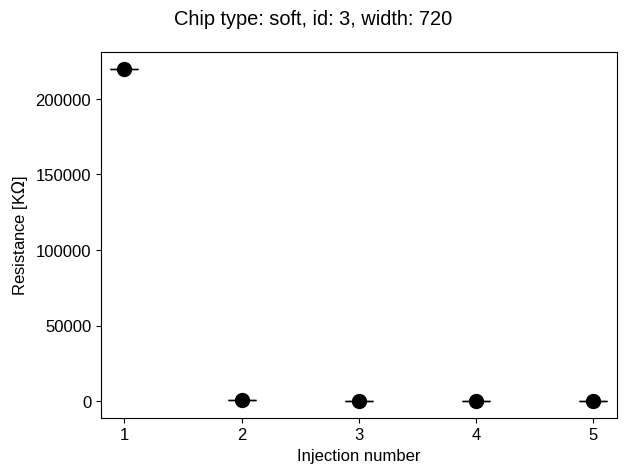

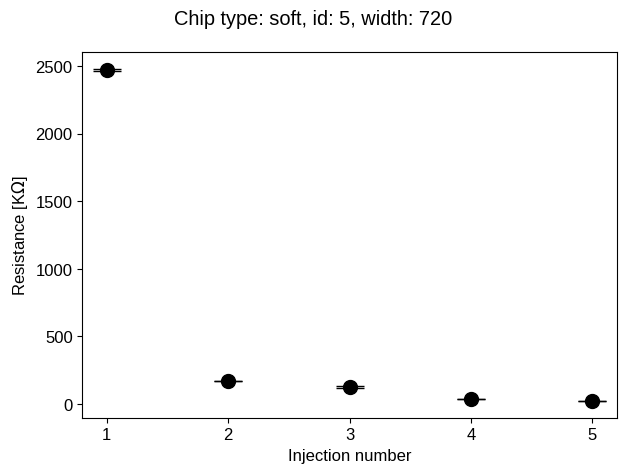

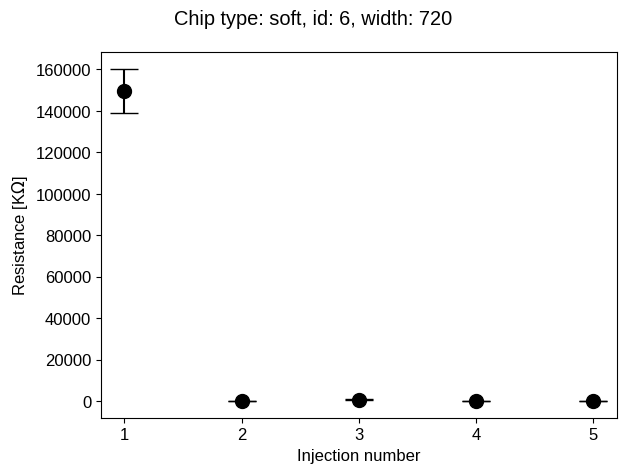

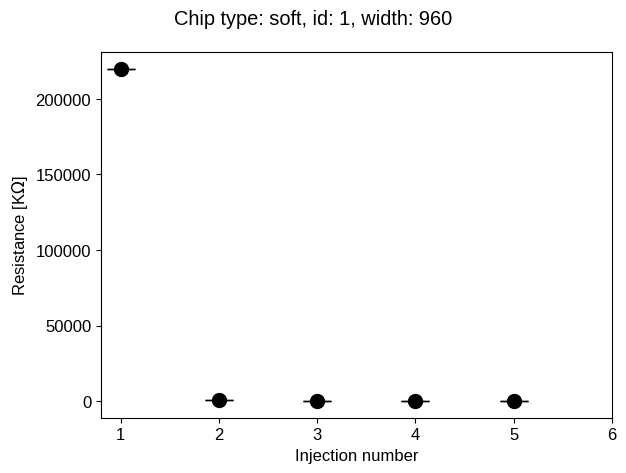

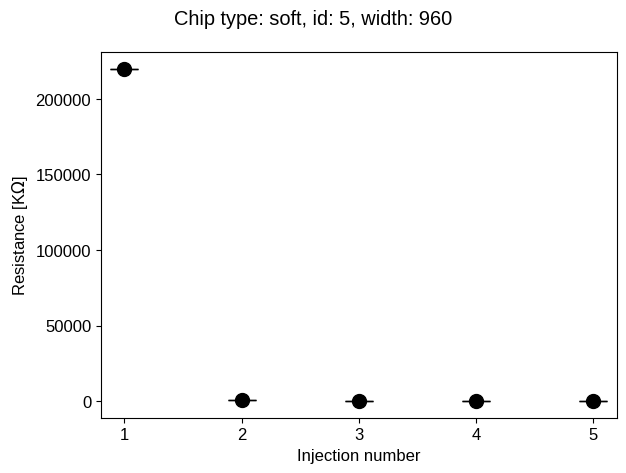

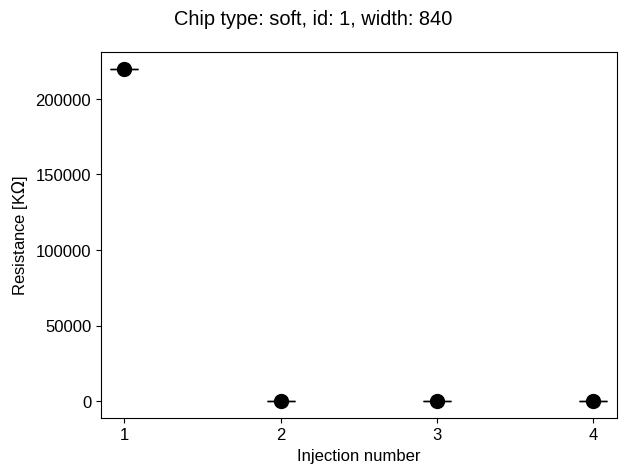

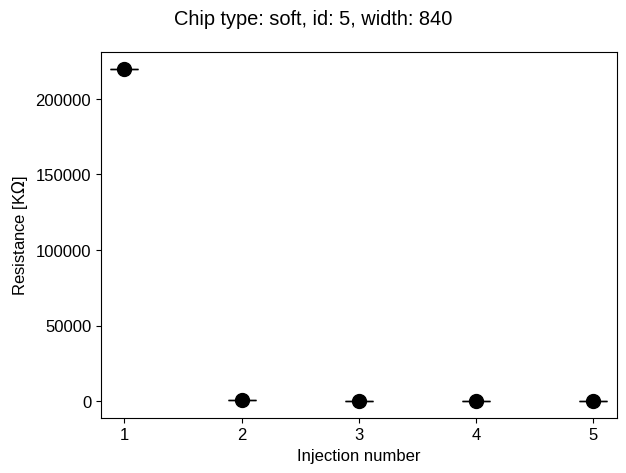

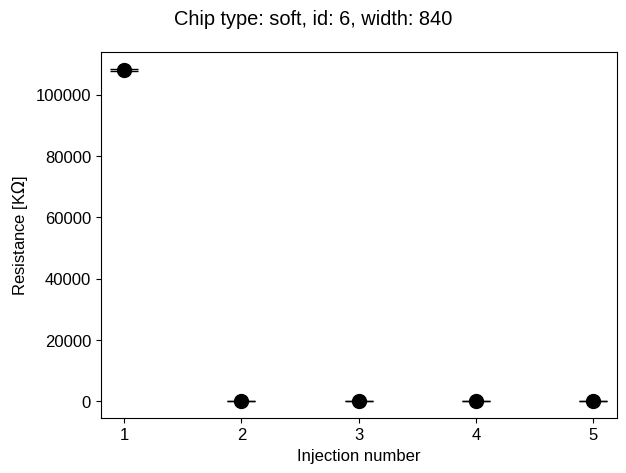

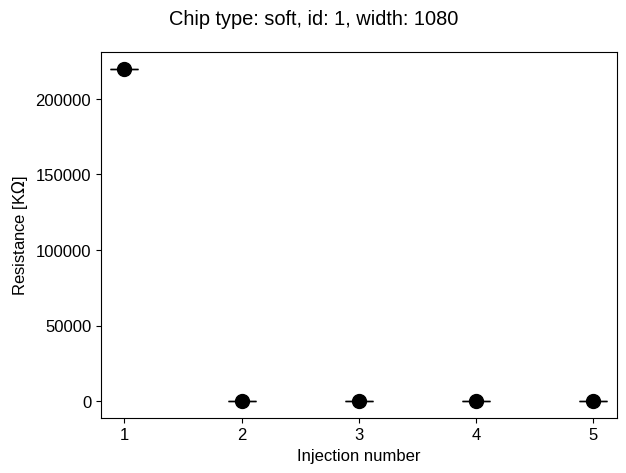

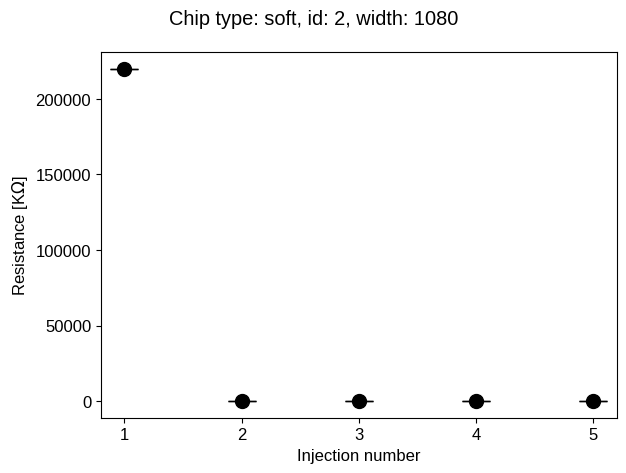

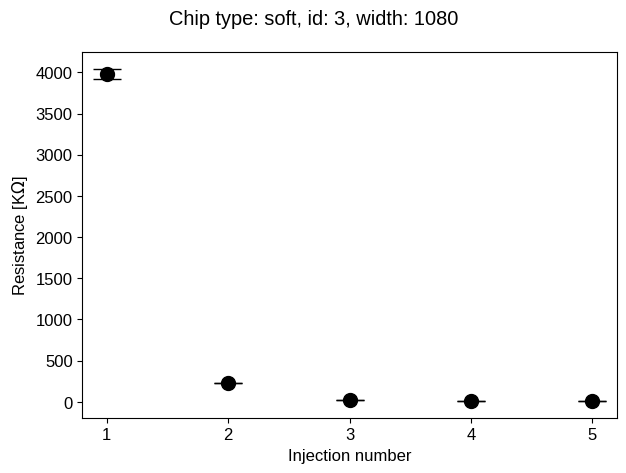

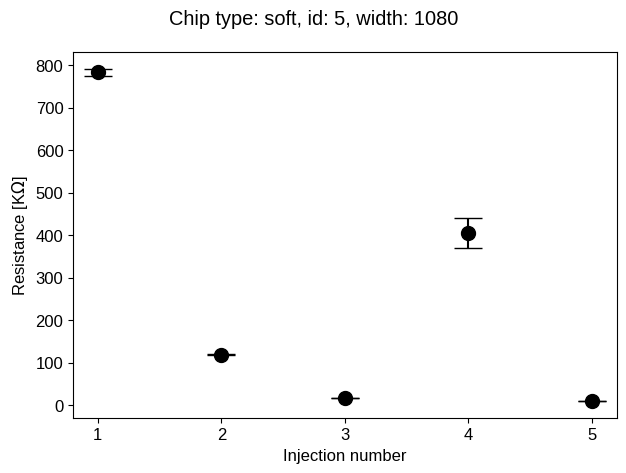

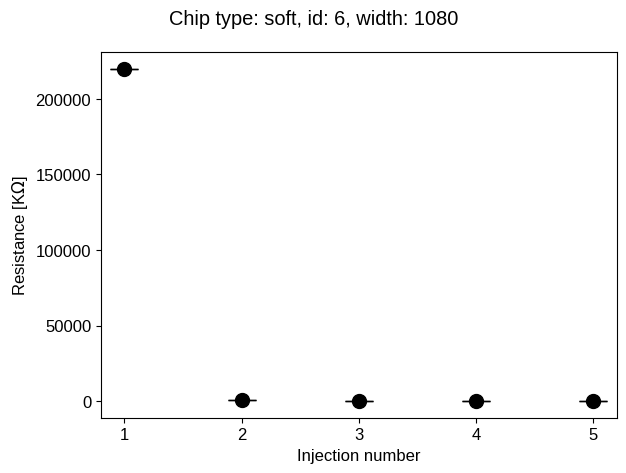

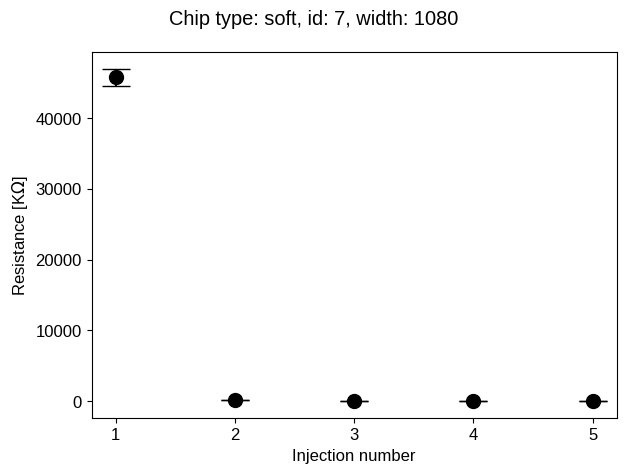

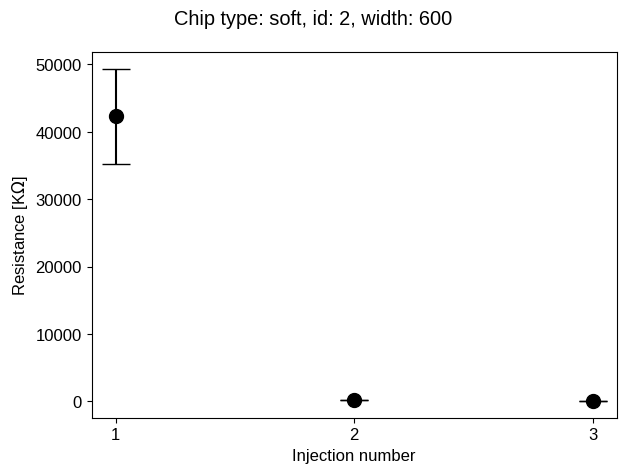

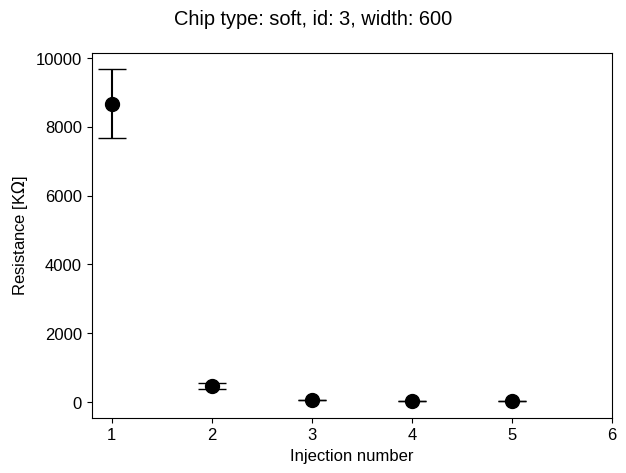

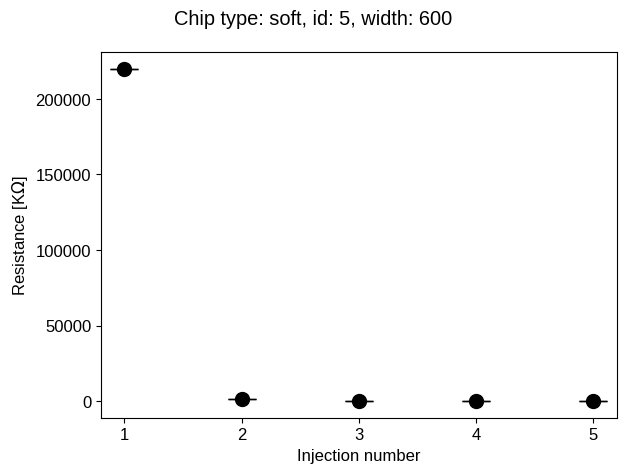

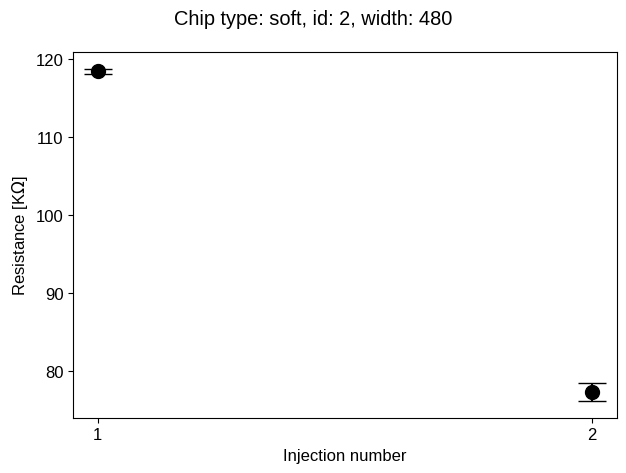

In [12]:
plotter_soft.run_individual_chips()

processing chip ID: (480, 2, 'soft')
aggregate from channel_datum: Channel Data: width: 480
xdata: [1, 2]
ydata: [118.4, 77.34]
yerr: [0.3546, 1.166]

item in ydata__aggregated: ([118.4, 77.34], [0.3546, 1.166])
data type of restructured_data: <class 'list'>
'item: [(118.4, 0.3546)]'
'item: [(77.34, 1.166)]'
stddevs: [0.3546]
cls.weights: [7.952845353104742]
weighted_ydata_: 118.4, weighted_yerr_: 3.5460000000000007
stddevs: [1.166]
cls.weights: [0.7355342479456529]
weighted_ydata_: 77.34, weighted_yerr_: 11.659999999999998
printing: width_480_type_soft_weighted_data.svg
processing chip ID: (600, 2, 'soft')
processing chip ID: (600, 3, 'soft')
processing chip ID: (600, 5, 'soft')
aggregate from channel_datum: Channel Data: width: 600
xdata: [1, 2, 3]
ydata: [42300.0, 122.4, 26.95]
yerr: [7077.0, 0.5537, 0.03176]

aggregate from channel_datum: Channel Data: width: 600
xdata: [1, 2, 3, 4, 5, 6]
ydata: [8674.0, 465.9, 57.92, 31.96, 21.26, 28.38]
yerr: [997.1, 86.62, 0.621, 0.1567, 0.0271,

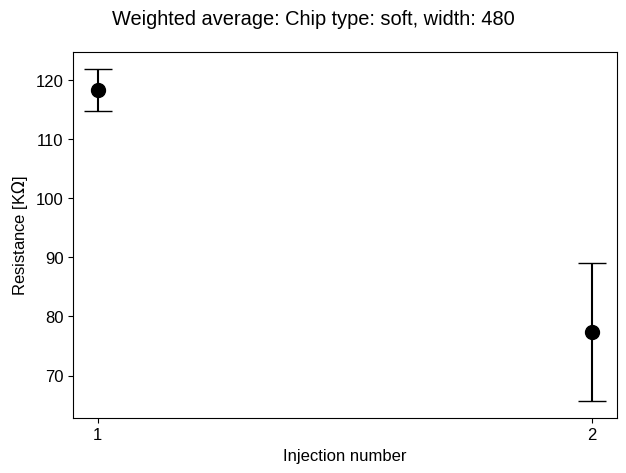

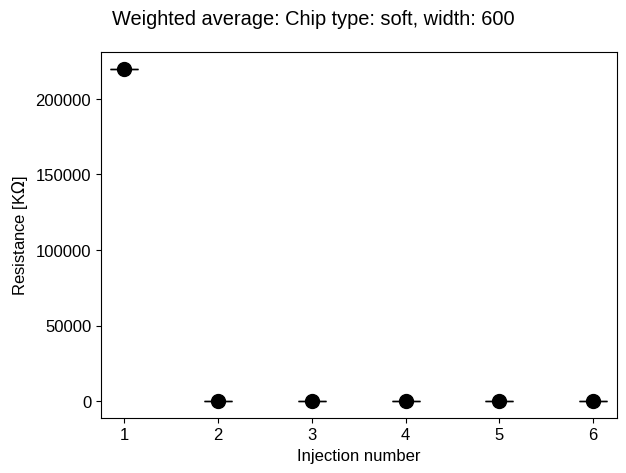

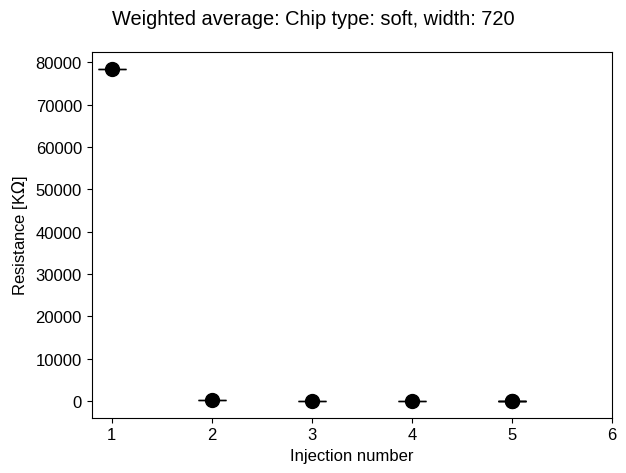

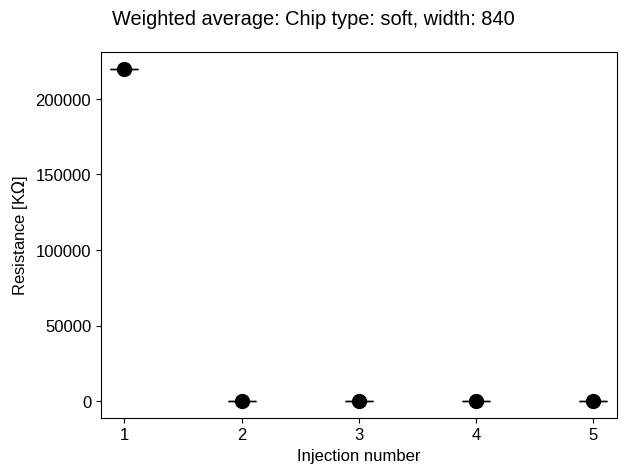

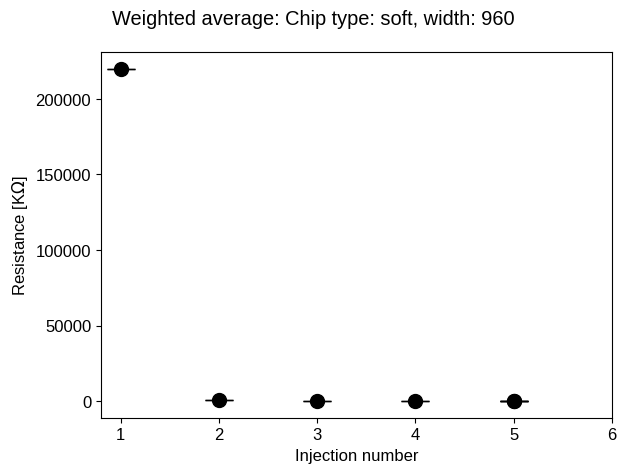

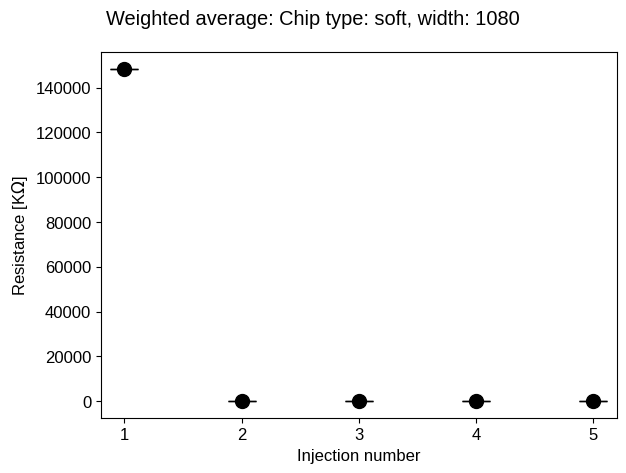

In [13]:
df = pd.DataFrame()
channel_widths = plotter_soft.get_channel_list()
for channel_width in channel_widths:
    data = plotter_soft.filter_by_width(width=channel_width)
    df_ = pd.DataFrame(plotter_soft.get_averaged_channel_data(data))
    df = pd.concat([df_, df])

In [14]:
path = os.path.join(PlotUtils.glob_figpath, 'weighted_data_soft.csv')
df.to_csv(path)
df

,chip_width,chip_type,number_of_chips,x_data,number_of_injections,y_data,y_err
0,1080,soft,6,1,5,148418.663586,22.446144
1,1080,soft,6,2,5,161.129226,1.479176
2,1080,soft,6,3,5,16.771089,0.003759
3,1080,soft,6,4,5,18.827472,0.072578
4,1080,soft,6,5,5,12.066851,0.033734
0,960,soft,2,1,6,220000.000000,50.000000
1,960,soft,2,2,6,453.724647,1.188805
2,960,soft,2,3,6,158.876657,1.739362
3,960,soft,2,4,6,55.221779,0.045290
4,960,soft,2,5,6,20.889527,0.002296


### Filter dataframe for last injection

In [15]:
df_last_injection = df.loc[df.x_data == df.number_of_injections]
df_last_injection

,chip_width,chip_type,number_of_chips,x_data,number_of_injections,y_data,y_err
4,1080,soft,6,5,5,12.066851,0.033734
4,840,soft,3,5,5,24.857453,1.286486
5,600,soft,3,6,6,28.380000,23.030000
1,480,soft,1,2,2,77.340000,11.660000


### Summary plots: resistance at each channel after last injection
The number of the last injection is variable, shown in the above tables in column `number_of_injections`.

[1080, 840, 600, 480]


/home/mkrause/dev/artificial-muscle/src/plot_utils.py:103: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


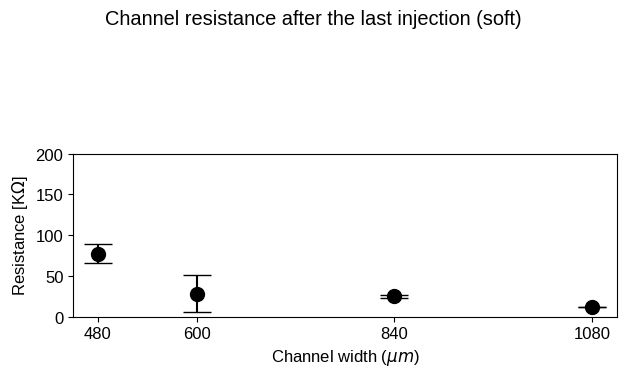

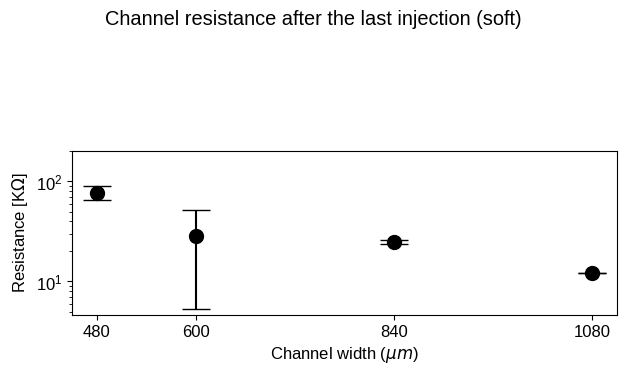

In [16]:
print(df_last_injection.chip_width.to_list())
title = 'Channel resistance after the last injection (soft)'
xlabel = 'Channel width ($\mu m$)'
aspect = 0.3

# with linear y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_soft_linear.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err, 
                       nrows=plotter_soft.nrows, ncols=plotter_soft.ncols, aspect = aspect,
                       xlabel=xlabel, ylabel=plotter_soft.ylabel, capsize=plotter_soft.capsize,
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format, ylim=[0, 200])

# with logrithmic y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_soft_logarithmic.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err, 
                       nrows=plotter_soft.nrows, ncols=plotter_soft.ncols, aspect = aspect,
                       xlabel=xlabel, ylabel=plotter_soft.ylabel, capsize=plotter_soft.capsize,
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format, ylim=[0, 200], yscale='log')